# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

Specific programming tasks are marked with a **ToDo** tag. 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

Each **ToDo** task below has an associated quiz present in the classroom.  Though the classroom quizzes are **not necessary** to complete the project, they help ensure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the [rubric](https://review.udacity.com/#!/rubrics/1214/view) specification. 


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [8]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.


**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [9]:
df = pd.read_csv('ab_data.csv')
df.head()


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [10]:
# Sampling Duration
df.timestamp.min(), df.timestamp.max()

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

**b.** Use the cell below to find the number of rows in the dataset.

In [11]:
len(df)

294478

**c.** The number of unique users in the dataset.

In [12]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [13]:
df.converted.mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [14]:
df.query('landing_page != "new_page" and group == "treatment"').count()[0]

1965

**f.** Do any of the rows have missing values?

In [15]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [16]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
index1 = df.query('landing_page == "new_page" and group != "treatment"').index
index2 = df.query('landing_page == "old_page" and group == "treatment"').index
#Drop inaccurate rows
df2 = df.drop(index1, axis=0)
df2 = df2.drop(index2, axis=0)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [17]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [18]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [19]:
df2.loc[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**c.** Display the rows for the duplicate **user_id**? 

In [20]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [21]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2.drop(2893, axis=0, inplace = True)
# Check again if the row with a duplicate user_id is deleted or not
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

$p_{population}$.



In [22]:
p_population = df2.converted.mean()
p_population

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [23]:
control_mean = df2[df2['group'] == 'control']['converted'].mean()

control_mean

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [24]:
treatment_mean = df2[df2['group'] == 'treatment']['converted'].mean()
treatment_mean

0.11880806551510564

In [25]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.

obs_diff = treatment_mean - control_mean
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [121]:
len(df2.query('landing_page == "new_page"'))/len(df2)

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>_Noting that the propability of either landing pages is at ~50% and that the propability of conversion for the old landing page is at 12.04% while the propability of conversion for the new landing page is at 11.88%, we observe that the old landing page performs slightly better at conversion, however, the difference is insignificant using descriptive statistics and implies no improvement on the conversion rate for the treatment group with the new landing page_

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>**Hypothesis :**
>
>$$H_{0} : p_{old} \geq p_{new}$$
>$$H_{1} : p_{old} < p_{new} $$

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [26]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [27]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [28]:
n_new = len(df2[df2['group'] == 'treatment'])
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [29]:
n_old = len(df2[df2['group'] == 'control'])
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [30]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.binomial(n_new, p_new)

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [31]:
# Simulate a Sample for the control Group
old_page_converted = np.random.binomial(n_new, p_new)

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [32]:
p_conv = (new_page_converted / n_new) - (old_page_converted / n_old)
p_conv

-6.407072763928157e-05


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [33]:
# Sampling distribution 
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new 
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

In [34]:
#Convert to numpy array
p_diffs = np.array(p_diffs)

In [35]:
np.count_nonzero(p_diffs < -0.001)

2072

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  


-4.808722791964859e-06

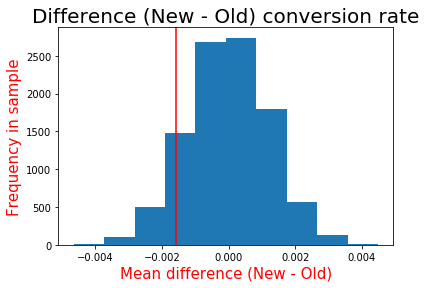

In [36]:
# Plot sampling distribution
plt.hist(p_diffs);
plt.title("Difference (New - Old) conversion rate", fontsize=20, color='k')
plt.ylabel("Frequency in sample", fontsize=15, color='r')
plt.xlabel("Mean difference (New - Old)", fontsize=15, color='r')

plt.axvline(obs_diff, c='red');
p_diffs.mean()


**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [37]:
# Compute p-value
(p_diffs > obs_diff).mean()

0.90080000000000005

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>**1.** The calculated value in **j** is the "P value" or 'Propability Value' which represents a statistical test to identify the propability of getting the observation, which is used as an alternative to the rejection at which the null hypothesis would be rejected when compared against the rejection criteria '$\alpha$' or Type I error rate which is set at 0.05 for this example.
>
>**2.** Based on the computed p-value of 0.9008 we fail to reject the null hypothesis and the alternative hypothesis is to be rejected instead as the propability did not reach the required threshhold defined by the Type I error, since it shows that the results obtained from using the new page provide a lower conversion rate.
>
>The same conclusion above can be observed from the histogram plot



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [38]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = len(df2.query('converted==1 and landing_page=="old_page"'))

# number of conversions with the new_page
convert_new = len(df2.query('converted==1 and landing_page=="new_page"'))

# number of individuals who were shown the old_page
n_old = len(df2.query('landing_page=="old_page"'))

# number of individuals who received new_page
n_new = len(df2.query('landing_page=="new_page"'))


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


> Warning is a pandas issue as per [3814](https://github.com/statsmodels/statsmodels/issues/3814) and
>                                  [3618](https://github.com/statsmodels/statsmodels/pull/3618)
> No action currently required

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.

In [39]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old, n_new],alternative='smaller')
print(z_score, p_value)


1.31092419842 0.905058312759


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>


>The p-value calculated above is 0.905 which is less than 0.95 required to reject the null hypothesis and the Z score calculated is 1.311 which is less than the 1.645 value provided in the two sample z-test explanation above. Both calculated scores are in line with the previous conclusion and we fail to reject the null hypothesis. 

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

_As the dependent variable is caterogical, the best model would be a logistic regression model._

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [40]:
# define intercept
df2['intercept'] = 1
# create treatment group dummy column
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [41]:
import statsmodels.api as sm
logit_mod=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results=logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [42]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-01-14 18:49 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  


>The p-value associated with the **ab_page** using logistic regression is calculated at _0.1899_. This value is well above the Type I error threshhold and implies that there is no relationship between the page presented to the user and the propability of conversion.
>
> In the previous analysis _Part 2_ we tried to assess whether the old page performed equally or better than the new page in terms of conversion as our null hypothesis, whilst in our logistic regression model we tried to identify whether or not there were any relationships across both the dependant and independant variables with the null hypothesis being there are no relationships among the variables.
>
> On both occassions the analysis failed to reject the null hypothesis concluding that the old landing page performs equally or better than the new page in the first instance and that conversion rate is not dependant on the page the user gets in the second
>
>The p-values differ because of the type of test. In Part 3.1 we considered a two-tailed test whereas in Part2 we had a one-tailed test.

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>With the addition of factors to the model it will be possible to explore relationships that were not initially identified leading to different modeling scenarios the would lead to valuable actionable findings. As we continue to try to identify and predict the relationship between a variable and response one drawback to considering multiple factor would be the size of the sample which could bias the conclusions as well as the possibility of some of the factors being dependant on variables that are not properly captured within the dataset. 


**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

 Provide the statistical output as well as a written response to answer this question.

In [43]:
# Read the countries.csv
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [44]:
# Join with the df2 dataframe
df_merged= countries.merge(df2)
df_merged.head()


,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [45]:
# Create the necessary dummy variables
# Assume UK as the baseline
df_merged[['US', 'CA']] = pd.get_dummies(df_merged['country'])[['US', "CA"]]
df_merged.head()


,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page,US,CA
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0


In [46]:
# Fit your model, and summarize the results
logit_mod=sm.Logit(df_merged['converted'],df_merged[['intercept', 'ab_page','US','CA']])
results=logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-01-14 18:51 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9794    0.0127  -155.4145  0.0000  -2.0044  -1.9544
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
US           -0.0099    0.0133    -0.7433  0.4573  -0.0359   0.0162
CA           -0.0506    0.0284    -1.7835  0.0745  -0.1063   0.0050
==================================================================

"""

>Considering a UK user with an old page as the baseline, the above regression model shows no significant statistical relationship between the different variables when compared against the type I error rate of 0.05, hence it is concluded that the actual location of the user in this case study has no effect on the conversion outcome.

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 


In [47]:
# Create the necessary dummy variables to assess if there is any interaction between page and country
# Assume UK as the baseline
df_merged['ab_US'] = df_merged['ab_page'] * df_merged['US']
df_merged['ab_CA'] = df_merged['ab_page'] * df_merged['CA']
df_merged.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page,US,CA,ab_US,ab_CA
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0,0,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0,1,0
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,0,0
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,0,0,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,0,0


In [48]:
# Fit your model, and summarize the results
logit_mod = sm.Logit(df_merged['converted'], df_merged[['intercept','ab_page','US','CA','ab_US', 'ab_CA']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-01-14 18:51 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
US            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
CA           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
ab_US        -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
ab_CA        -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
==================================================================

"""

>The above regression model shows,as well,  no significant statistical relationship between the different variables when compared against the type I error rate of 0.05, hence it is concluded that the interaction between page and country has no significant effects on the conversion rate.
>
>Neverthless, despite failing to reject the null hypothesis of the old page generating more views than the old page, and the null hypothesis of the choice of page affects and conversion rate as well as identifying that neither the country of the user does affect the conclusion previously established nor is there a statistically significant interaction between the landing page and the country. The study failed to take into consideration the duration of the sampling for the data set of 22 days and the results could have been biased based on the possibility that a group of users could have accessed the old page pre the sampling date and received the new page during the data sampling period with the change affecting the decision, hence it might be benefecial to run the experiment for a longer duration prior to making an educated guess based on the sampled data.

In [49]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0